In [1]:
#imports
import os
import json
import pandas as pd
import polars as pl
from utils import list_folders, json_to_dataframe, list_all_files, add_districts, district_avg_position_by_capacity, district_avg_position

main_folder = 'snapshots'
dates = list_folders(main_folder)
files = list_all_files(main_folder, dates)

#stations_data = json_to_polar_dataframe(files)
stations_data = json_to_dataframe(files)
# Extact the columns timestamp, station_id, num_bikes_available


In [2]:
stations_data_filtered = stations_data[['timestamp_file', 'station_id', 'num_bikes_available']].sort_values(by=['station_id','timestamp_file'])
stations_data_filtered['diff'] = stations_data_filtered.groupby('station_id')['num_bikes_available'].diff().fillna(0)
stations_data_filtered['in_bikes'] = stations_data_filtered['diff'].apply(lambda x: x if x > 0 else 0)
stations_data_filtered['out_bikes'] = stations_data_filtered['diff'].apply(lambda x: -x if x < 0 else 0)
stations_data_filtered.drop('diff', axis=1, inplace=True)

/var/folders/md/jgs9sl817gxfmk03qhzt6bk80000gq/T/ipykernel_36239/1054803763.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  flow_agg['timestamp_file'] = pd.to_datetime(flow_agg['timestamp_file'], unit='s')


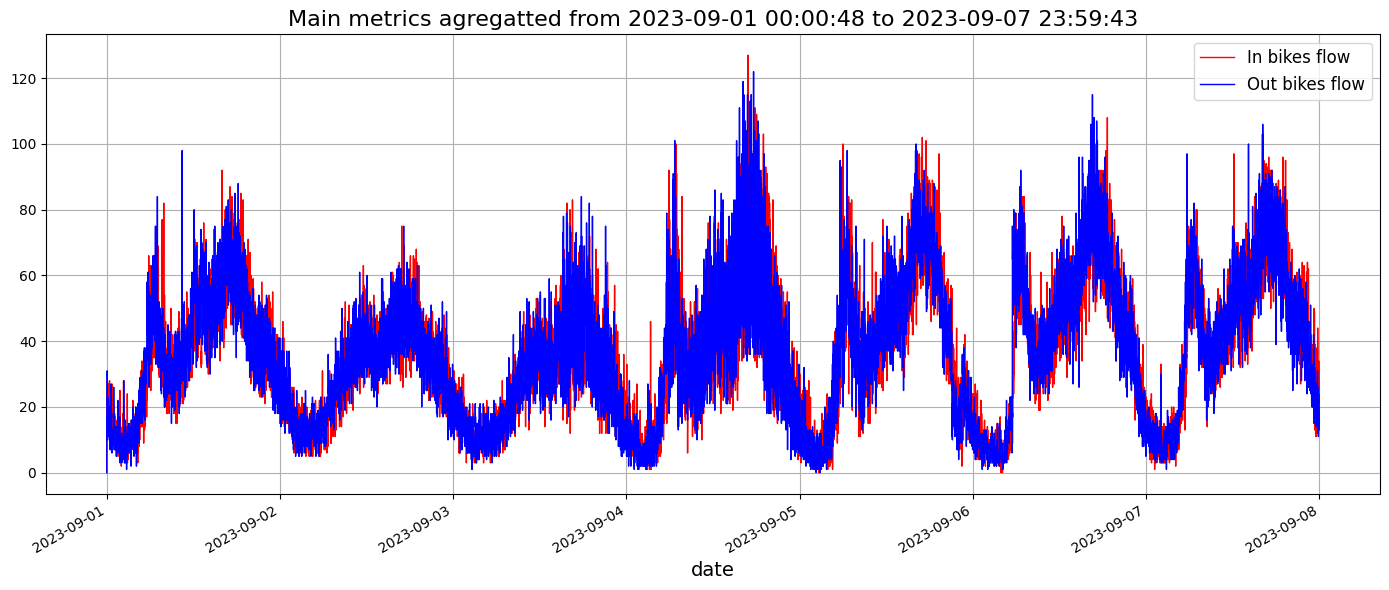

In [3]:
flow_agg = stations_data_filtered.groupby('timestamp_file')[['in_bikes', 'out_bikes']].sum().reset_index()
flow_agg['timestamp_file'] = pd.to_datetime(flow_agg['timestamp_file'], unit='s')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter

# 1 septiembre 2023 -> viernes
plt.figure(figsize=(14, 6))

plt.plot(flow_agg['timestamp_file'], flow_agg['in_bikes'], label='In bikes flow', color='red', linewidth=1)
plt.plot(flow_agg['timestamp_file'], flow_agg['out_bikes'], label='Out bikes flow', color='blue', linewidth=1)

plt.title('Main metrics agregatted from ' + str(flow_agg['timestamp_file'].min()) + ' to ' + str(flow_agg['timestamp_file'].max()), fontsize=16)
plt.xlabel('date', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

In [5]:
flow_agg.set_index('timestamp_file', inplace=True)
flow_agg['in_bikes_hourly_sum'] = flow_agg['in_bikes'].rolling(window='1').mean()
flow_agg['out_bikes_hourly_sum'] = flow_agg['out_bikes'].rolling(window='1').mean()
flow_agg.reset_index(inplace=True)

# 1 septiembre 2023 -> viernes
plt.figure(figsize=(14, 6))

plt.plot(flow_agg['timestamp_file'], flow_agg['in_bikes_hourly_sum'], label='In bikes flow hourly', color='red', linewidth=1)
plt.plot(flow_agg['timestamp_file'], flow_agg['out_bikes_hourly_sum'], label='Out bikes flow hourly', color='blue', linewidth=1)


plt.title('Main metrics agregatted hourly from ' + str(flow_agg['timestamp_file'].min()) + ' to ' + str(flow_agg['timestamp_file'].max()), fontsize=16)
plt.xlabel('date', fontsize=14)
plt.ylabel('Number of Bikes Available', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

KeyError: "None of ['timestamp_file'] are in the columns"

/var/folders/md/jgs9sl817gxfmk03qhzt6bk80000gq/T/ipykernel_36239/3534242473.py:32: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  flow_agg['timestamp_file'] = pd.to_datetime(flow_agg['timestamp_file'], unit='s', errors='coerce')


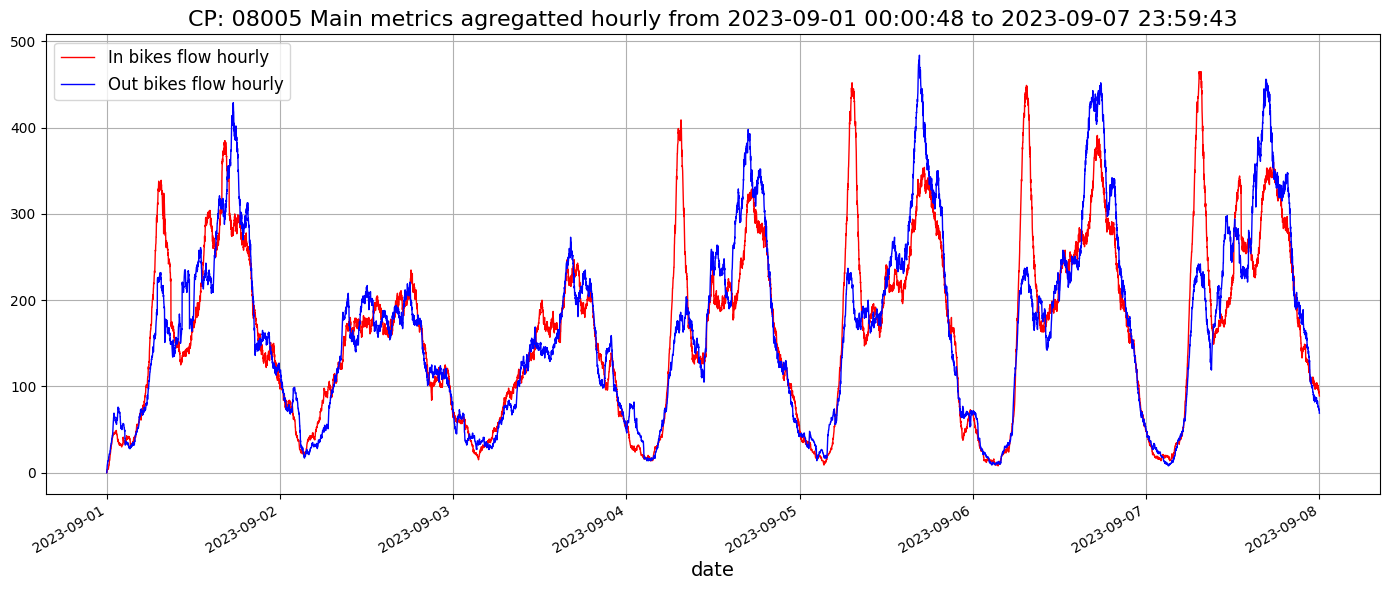

In [6]:
import matplotlib.pyplot as plt
# Stations master file
#URL: https://opendata-ajuntament.barcelona.cat/data/es/dataset/informacio-estacions-bicing
stations_master_file = main_folder+ '/2024_05_Maig_BicingNou_INFORMACIO.csv'

# Polars
#stations_master = pl.read_csv(stations_master_file, ignore_errors = True)

# Pandas

stations_master = pd.read_csv(stations_master_file, low_memory= False).sort_values(by='station_id')
stations_master['last_updated'] = pd.to_datetime(stations_master['last_updated'],errors='coerce')
stations_master = stations_master.sort_values('last_updated').groupby('station_id').last()

#stations_master.sort_values(by='altitude', ascending=False, inplace=True)
stations_master#.head(5)
#PC: 08022 -> Highest average altitude
#PC: 08005 -> highest capacity
station_pc = stations_master[stations_master['post_code'] == 8005]['short_name'].to_list()
station_ids = []
for station in station_pc:
    station_ids.append(str(int(station)))

stations_data_filtered = stations_data[['timestamp_file', 'station_id', 'num_bikes_available']].sort_values(by=['station_id','timestamp_file'])
stations_data_filtered = stations_data_filtered[stations_data_filtered['station_id'].isin(station_ids)]
stations_data_filtered['diff'] = stations_data_filtered.groupby('station_id')['num_bikes_available'].diff().fillna(0)
stations_data_filtered['in_bikes'] = stations_data_filtered['diff'].apply(lambda x: x if x > 0 else 0)
stations_data_filtered['out_bikes'] = stations_data_filtered['diff'].apply(lambda x: -x if x < 0 else 0)
stations_data_filtered.drop('diff', axis=1, inplace=True)
 
flow_agg = stations_data_filtered.groupby('timestamp_file')[['in_bikes', 'out_bikes']].sum().reset_index()
flow_agg['timestamp_file'] = pd.to_datetime(flow_agg['timestamp_file'], unit='s', errors='coerce')

flow_agg.set_index('timestamp_file', inplace=True)
flow_agg['in_bikes_hourly_sum'] = flow_agg['in_bikes'].rolling(window='1h').sum()
flow_agg['out_bikes_hourly_sum'] = flow_agg['out_bikes'].rolling(window='1h').sum()
flow_agg.reset_index(inplace=True)

# 1 septiembre 2023 -> viernes
plt.figure(figsize=(14, 6))

plt.plot(flow_agg['timestamp_file'], flow_agg['in_bikes_hourly_sum'], label='In bikes flow hourly', color='red', linewidth=1)
plt.plot(flow_agg['timestamp_file'], flow_agg['out_bikes_hourly_sum'], label='Out bikes flow hourly', color='blue', linewidth=1)


plt.title('CP: 08005 Main metrics agregatted hourly from ' + str(flow_agg['timestamp_file'].min()) + ' to ' + str(flow_agg['timestamp_file'].max()), fontsize=16)
plt.xlabel('date', fontsize=14)
#plt.ylabel('Number of Bikes Available', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

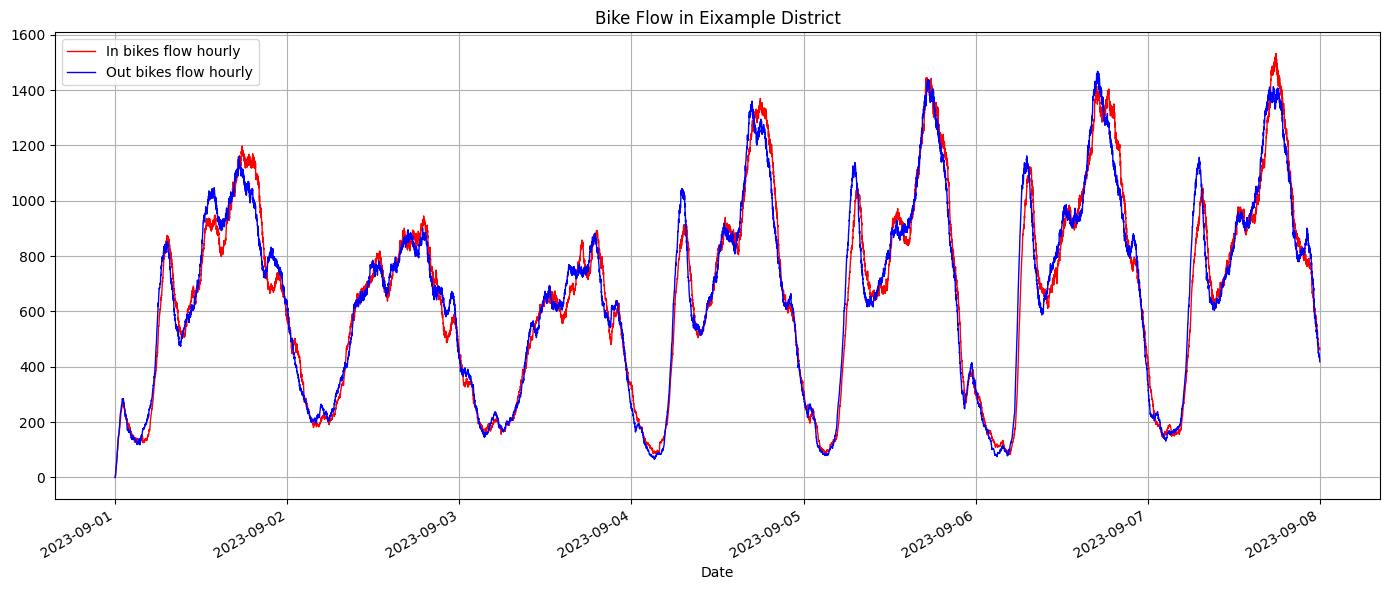

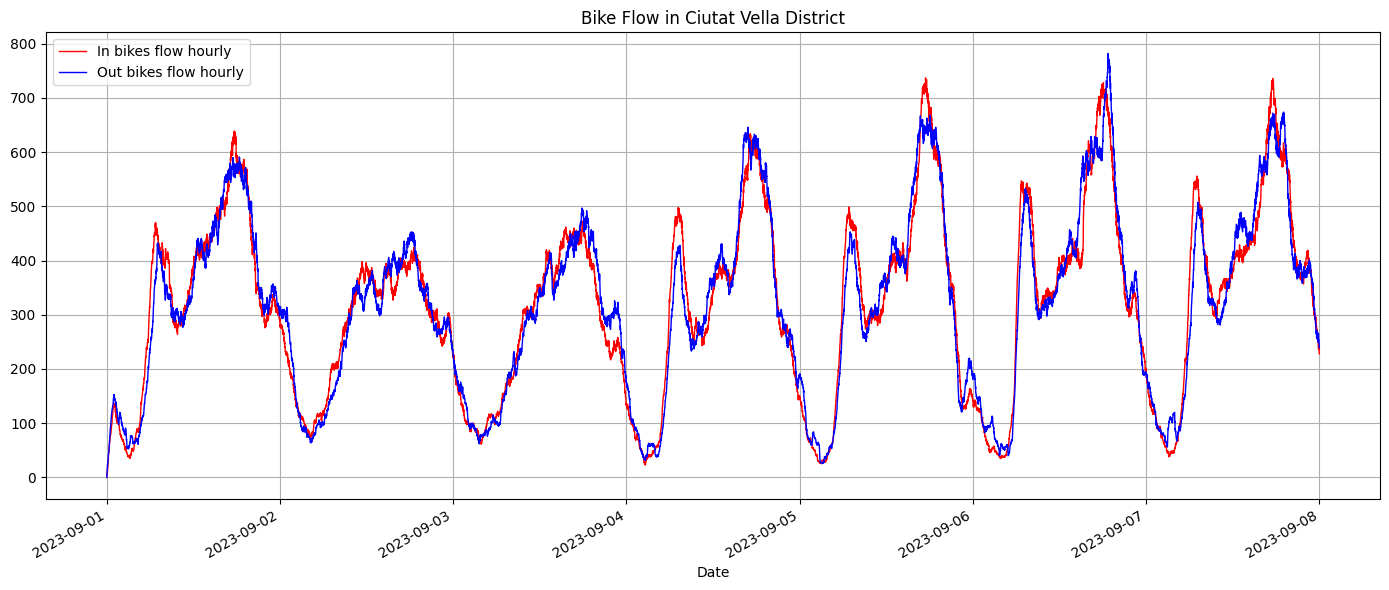

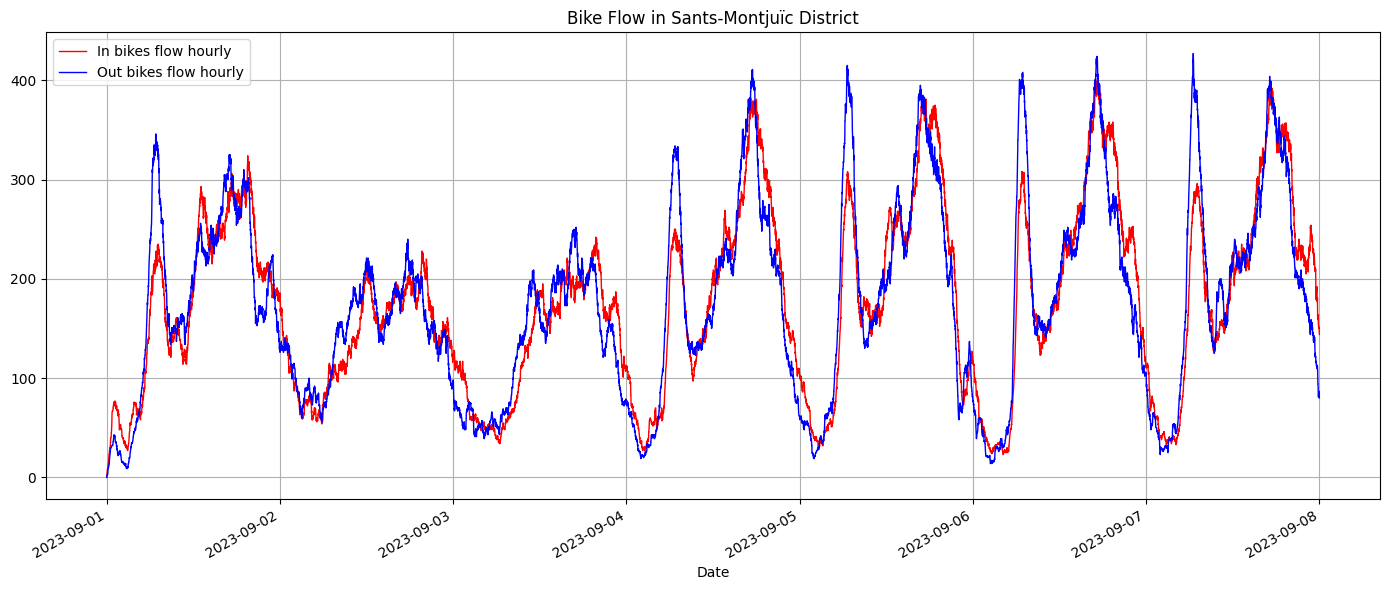

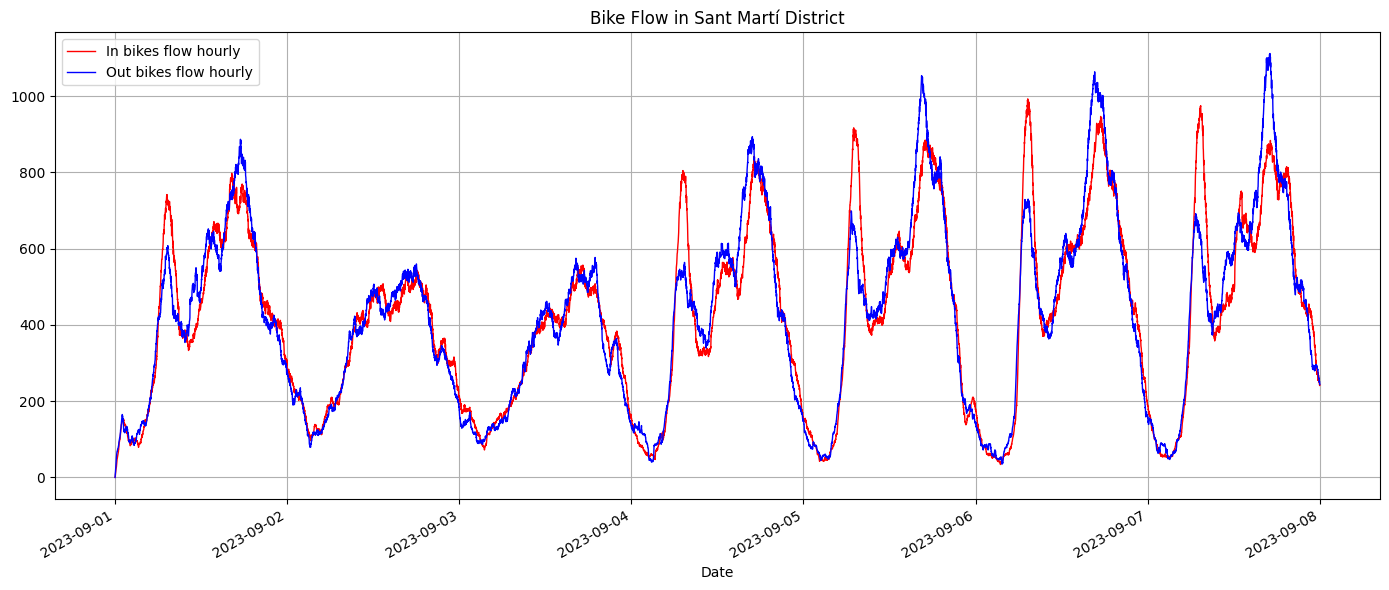

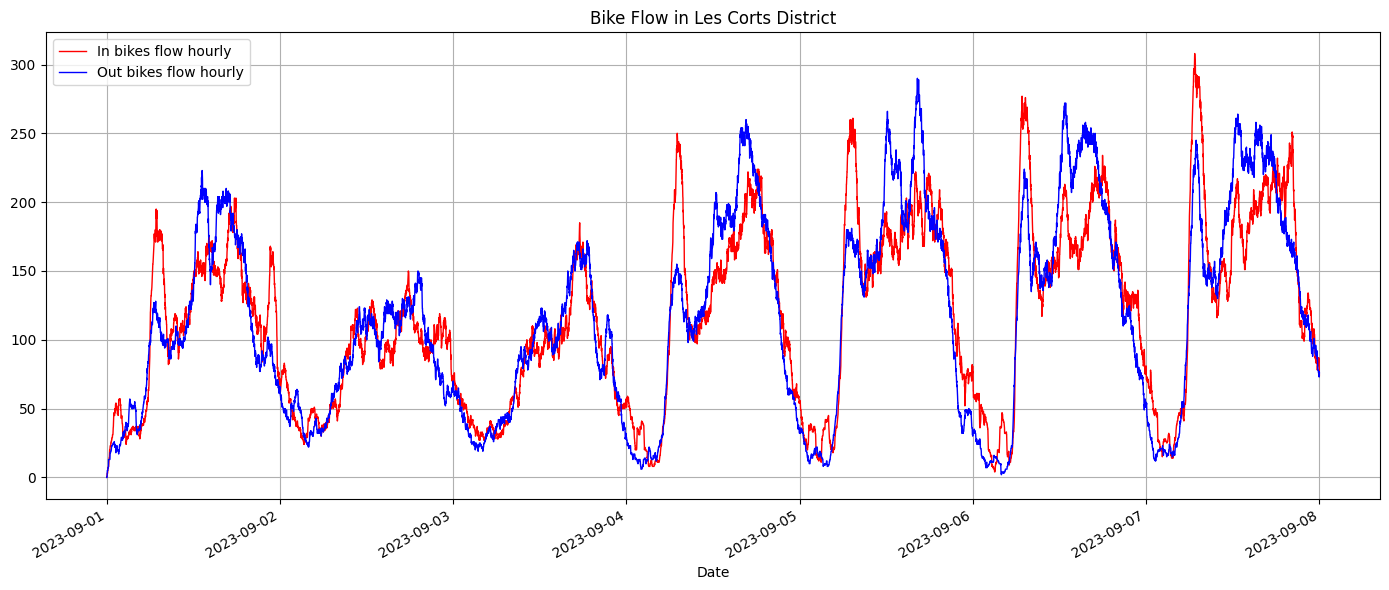

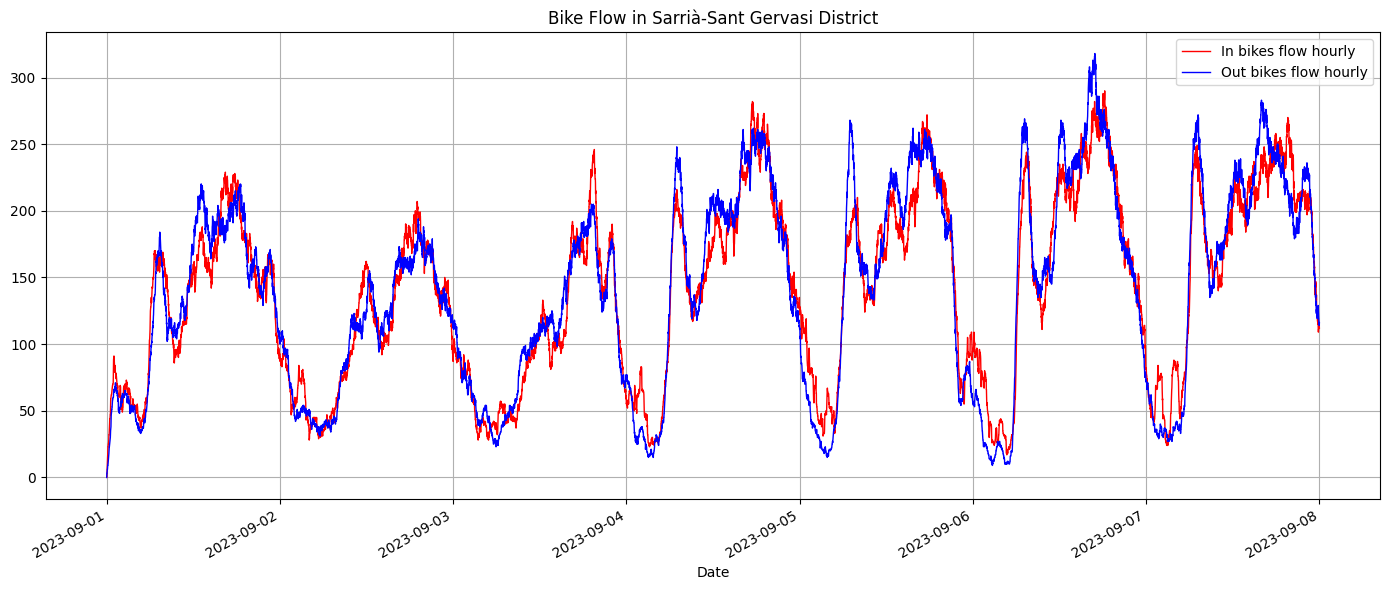

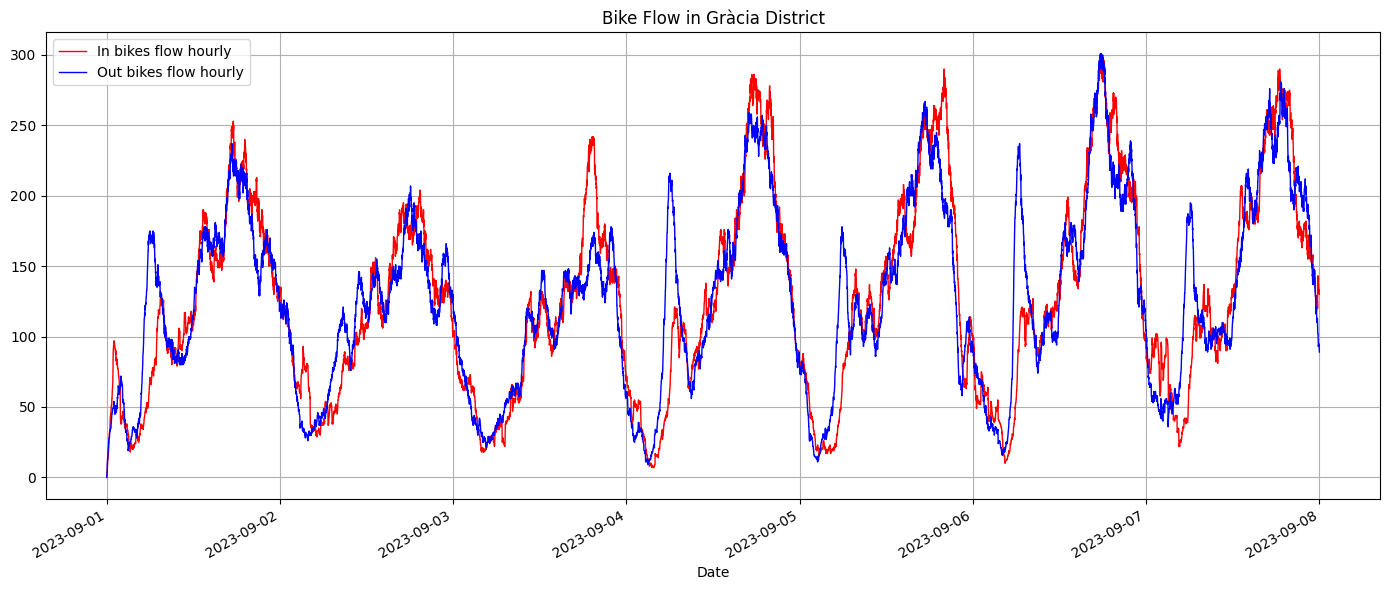

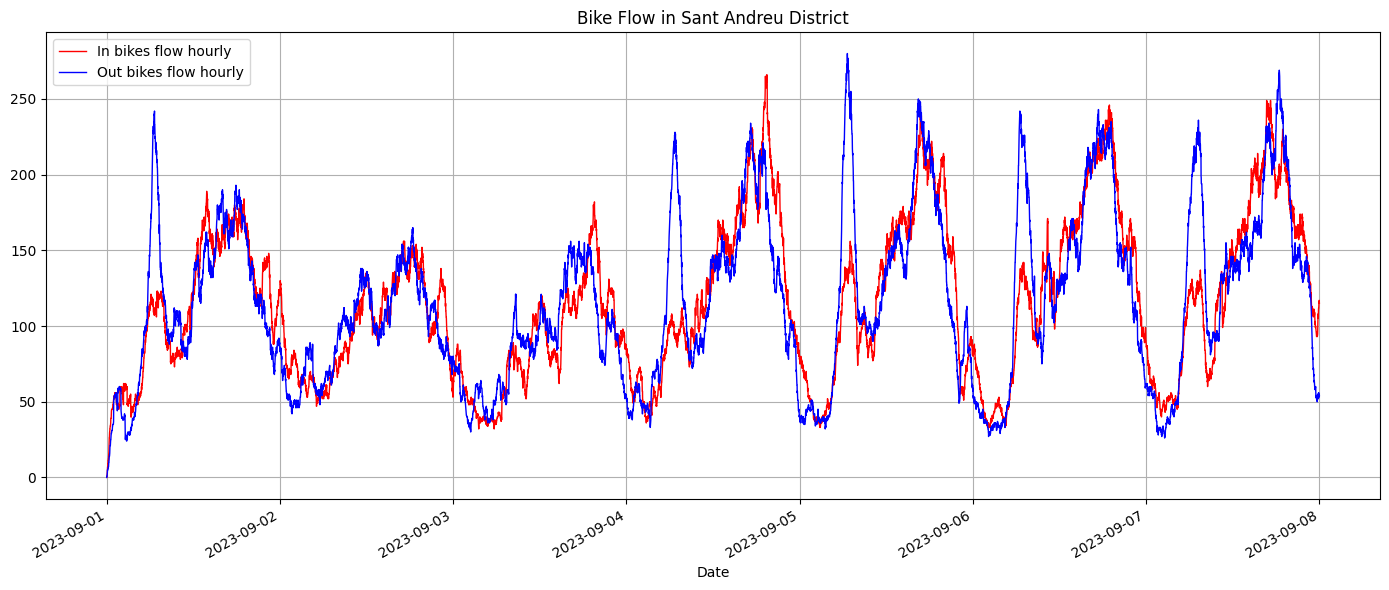

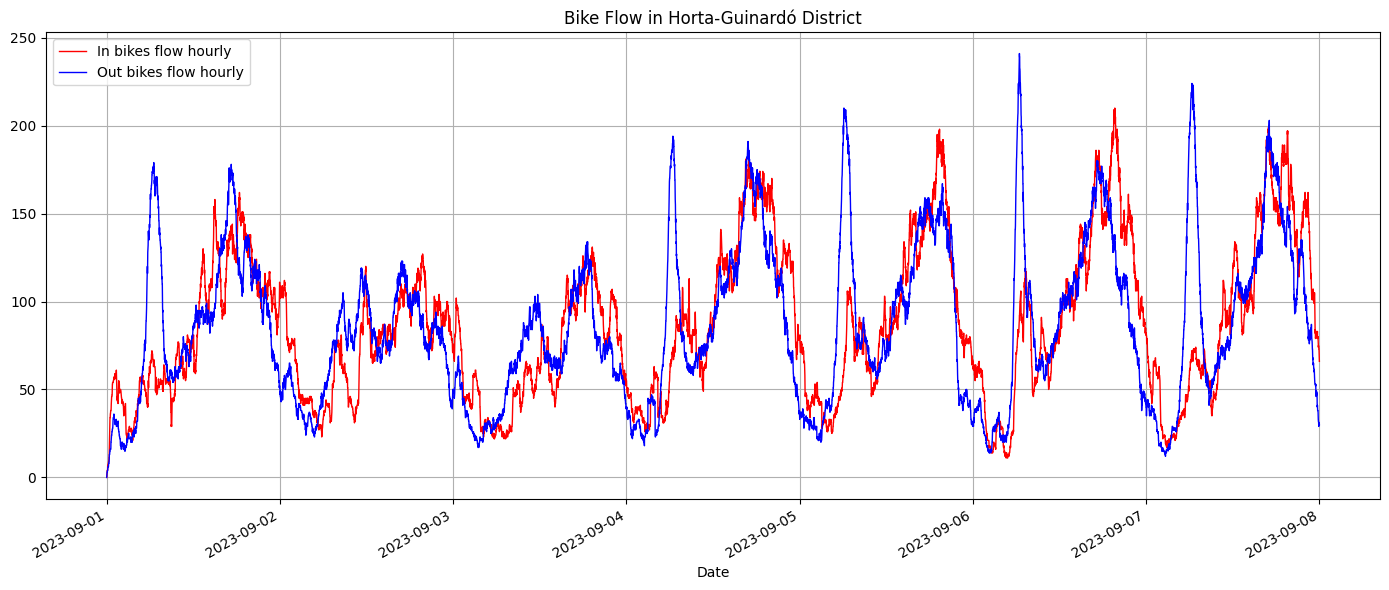

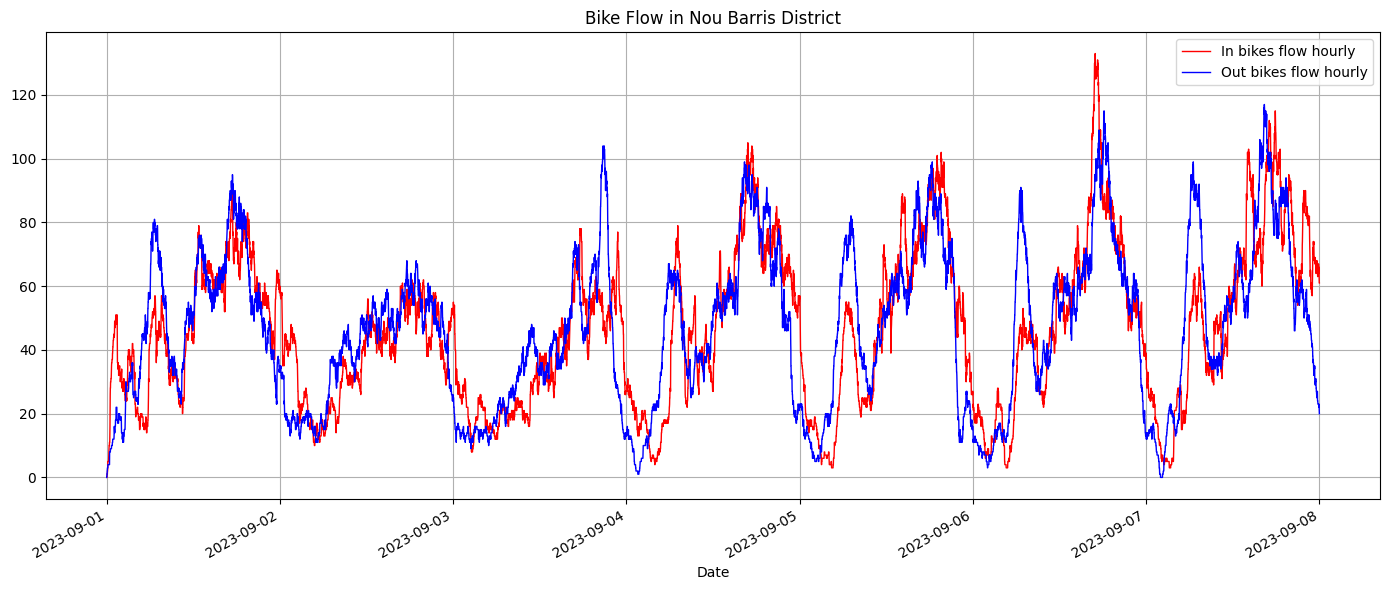

In [7]:
pd.options.mode.chained_assignment = None 
# Load data
stations_master_file = main_folder + '/2024_05_Maig_BicingNou_INFORMACIO.csv'

# Read and sort station master data
stations_master = pd.read_csv(stations_master_file, low_memory=False)
stations_master['last_updated'] = pd.to_datetime(stations_master['last_updated'])
stations_master = stations_master.sort_values('last_updated').groupby('station_id').last()

# Add districts to stations data
stations_master = add_districts(stations_master)

stations_data = json_to_dataframe(files)
stations_data = stations_data[['timestamp_file', 'station_id', 'num_bikes_available']].sort_values(by=['station_id','timestamp_file'])

# Assuming 'stations_data' is defined elsewhere and properly loaded
districts = stations_master['district'].unique()

for district in districts:
    stations_in_district = stations_master[stations_master['district'] == district]['short_name'].tolist()
    stations_in_district = [str(int(station)) for station in stations_in_district]

    stations_data_filtered = stations_data[stations_data['station_id'].isin(stations_in_district)]
    
    stations_data_filtered.loc[:, 'diff'] = stations_data_filtered.groupby('station_id')['num_bikes_available'].diff().fillna(0)
    stations_data_filtered.loc[:, 'in_bikes'] = stations_data_filtered['diff'].apply(lambda x: x if x > 0 else 0)
    stations_data_filtered.loc[:, 'out_bikes'] = stations_data_filtered['diff'].apply(lambda x: -x if x < 0 else 0)
    
    
    stations_data_filtered.drop('diff', axis=1, inplace=True)

  
    flow_agg = stations_data_filtered.groupby('timestamp_file')[['in_bikes', 'out_bikes']].sum().reset_index()
    flow_agg['timestamp_file'] = pd.to_datetime(flow_agg['timestamp_file'].astype(int), unit='s')
    flow_agg.set_index('timestamp_file', inplace=True)
    flow_agg['in_bikes_hourly_sum'] = flow_agg['in_bikes'].rolling(window='1h').sum()
    flow_agg['out_bikes_hourly_sum'] = flow_agg['out_bikes'].rolling(window='1h').sum()
    flow_agg.reset_index(inplace=True)


    plt.figure(figsize=(14, 6))
    plt.plot(flow_agg['timestamp_file'], flow_agg['in_bikes_hourly_sum'], label='In bikes flow hourly', color='red', linewidth=1)
    plt.plot(flow_agg['timestamp_file'], flow_agg['out_bikes_hourly_sum'], label='Out bikes flow hourly', color='blue', linewidth=1)
    plt.title(f'Bike Flow in {district} District')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()


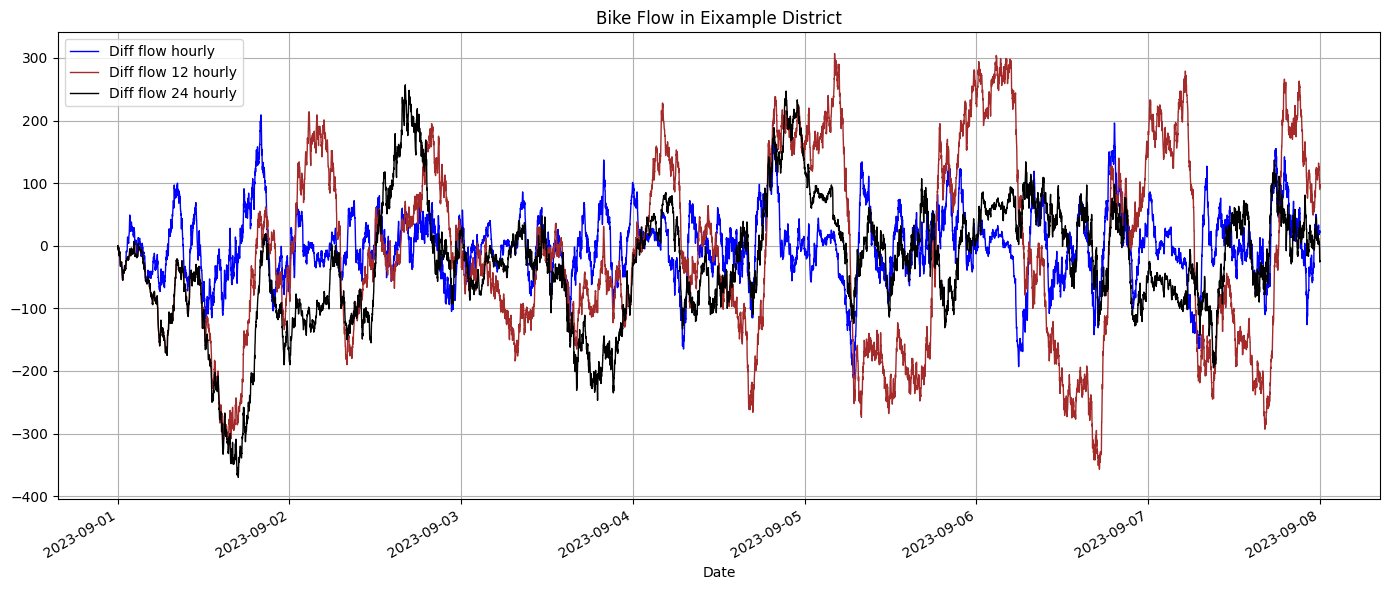

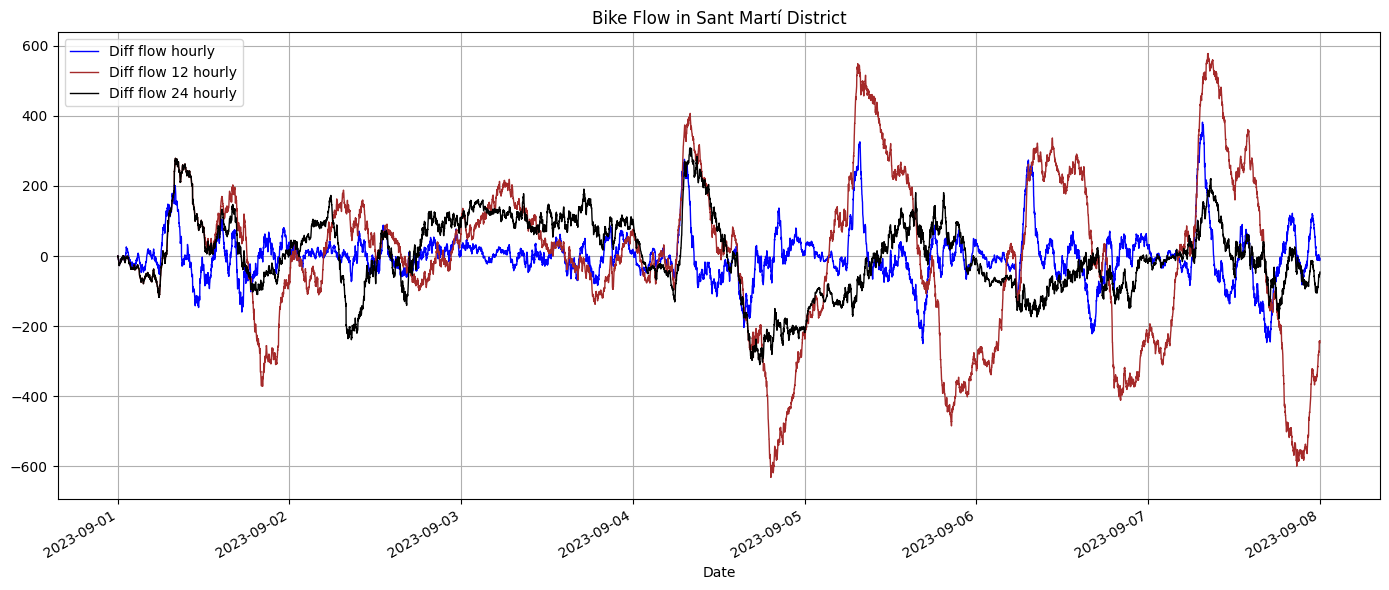

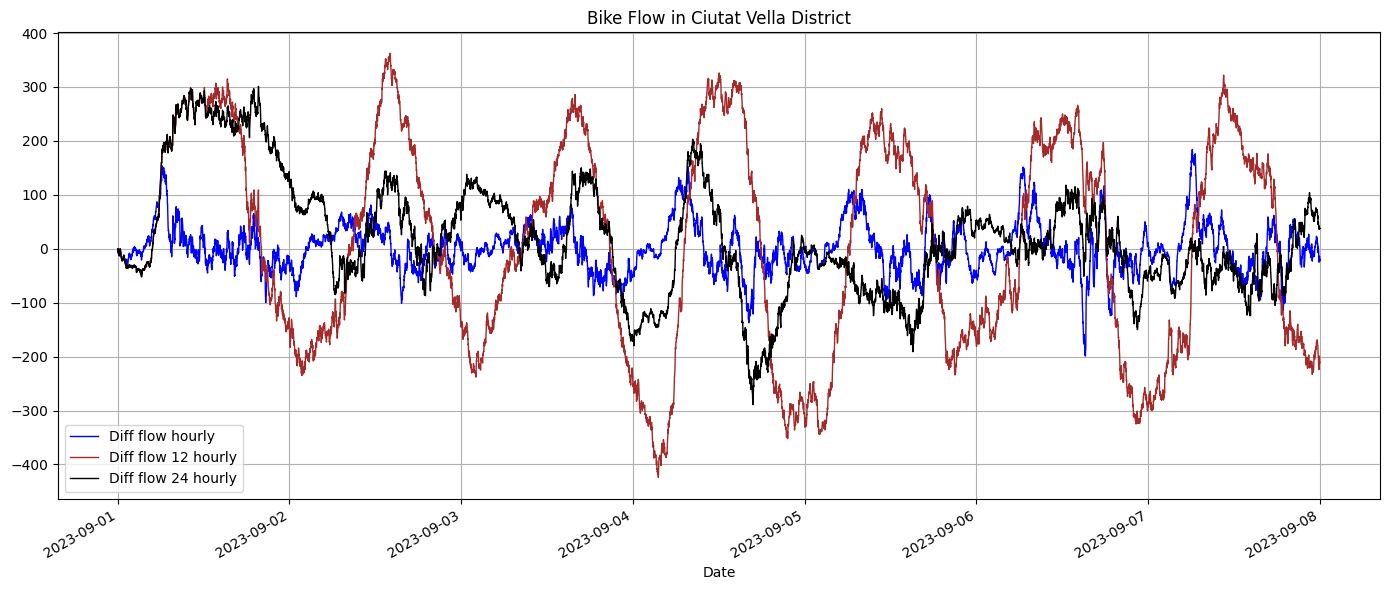

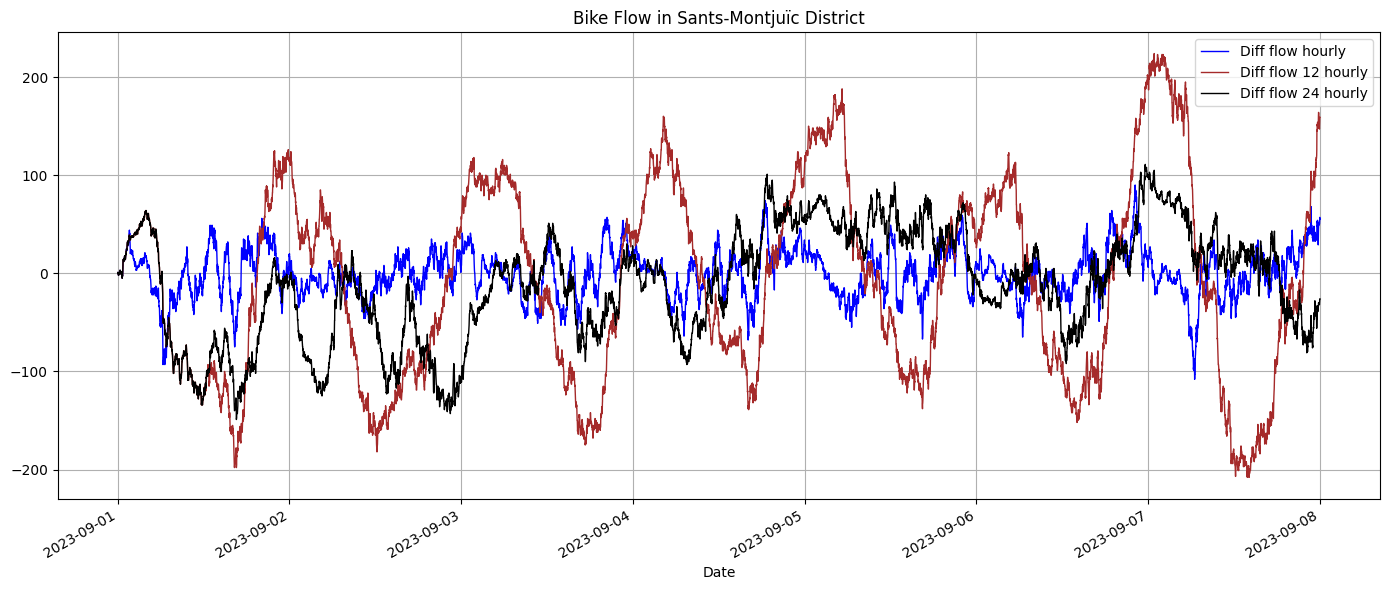

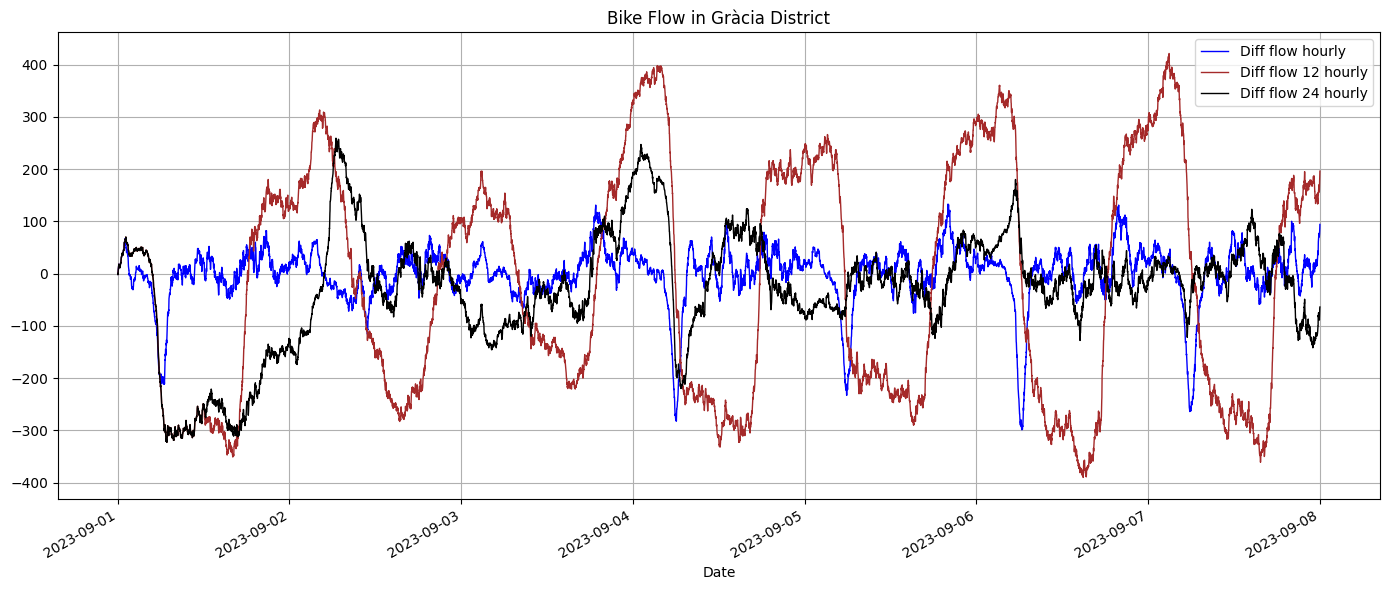

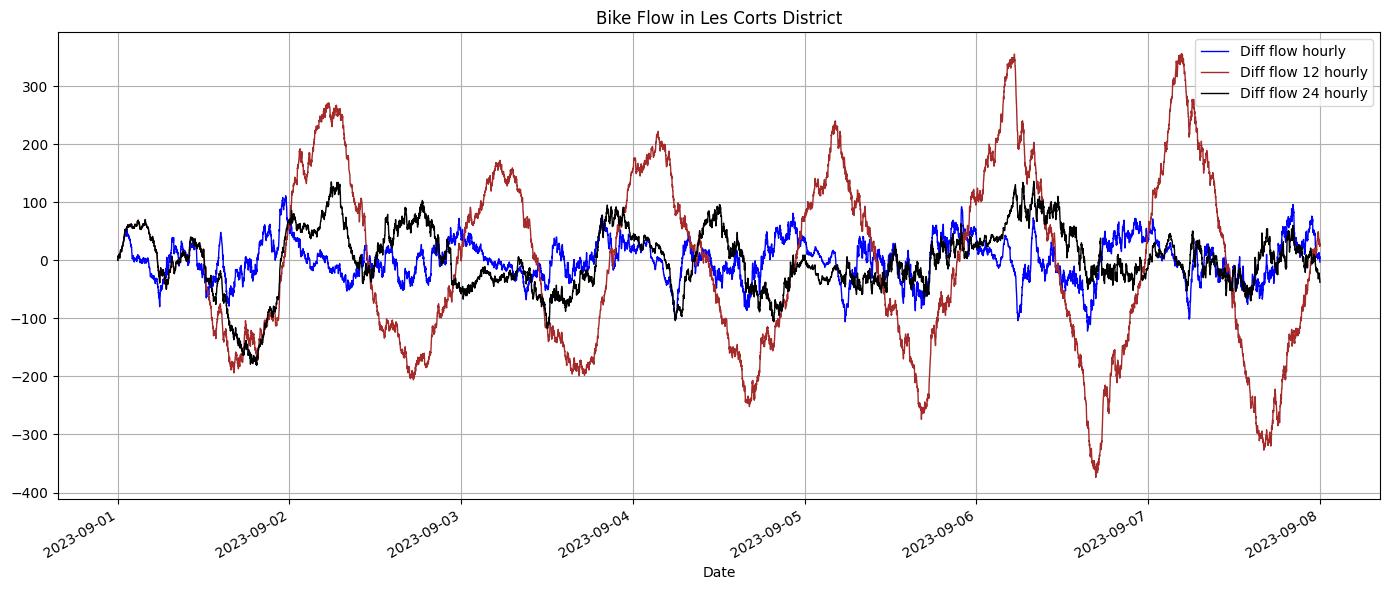

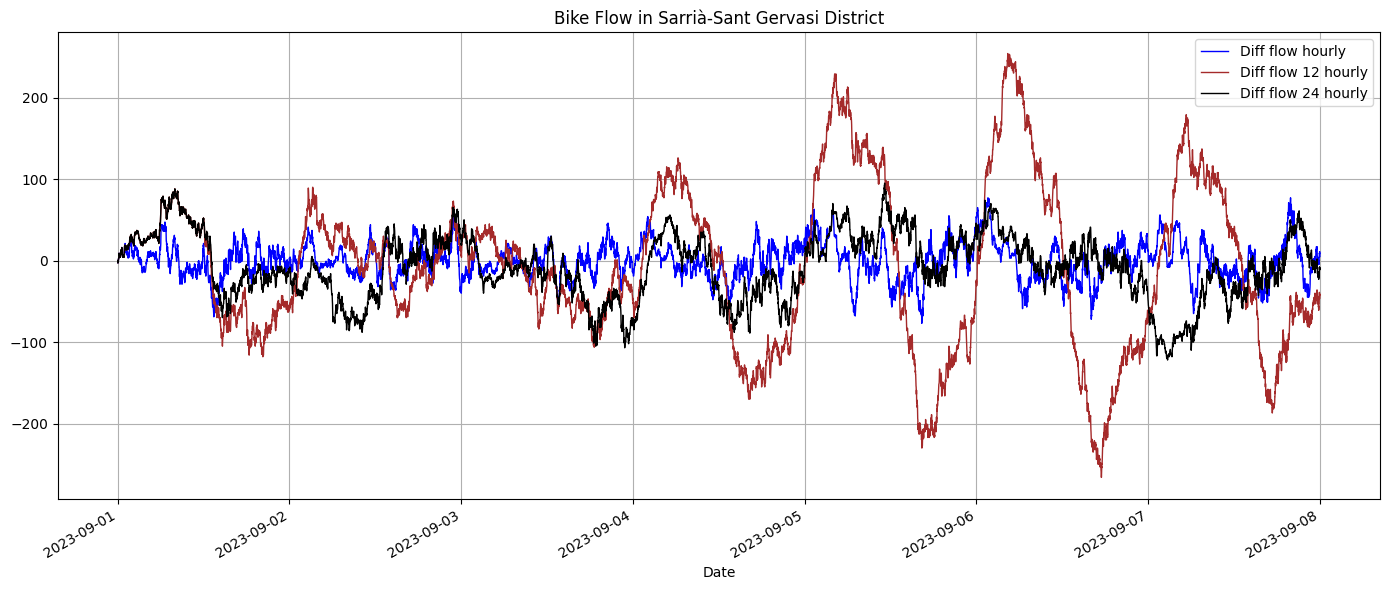

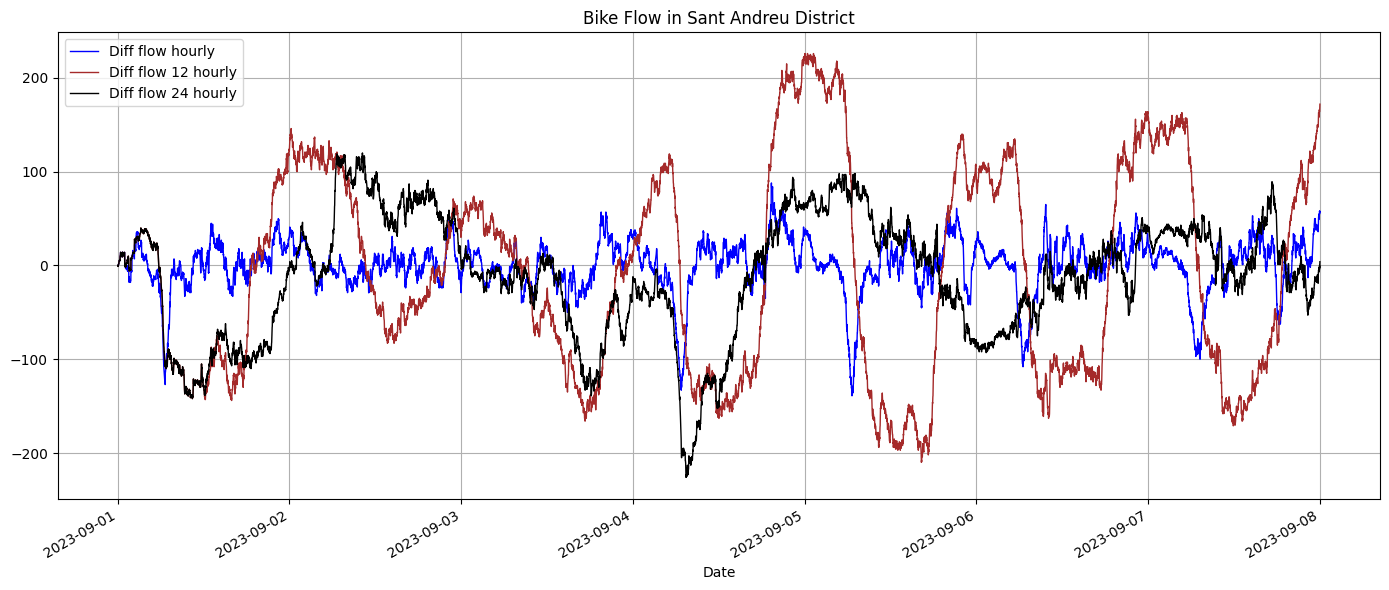

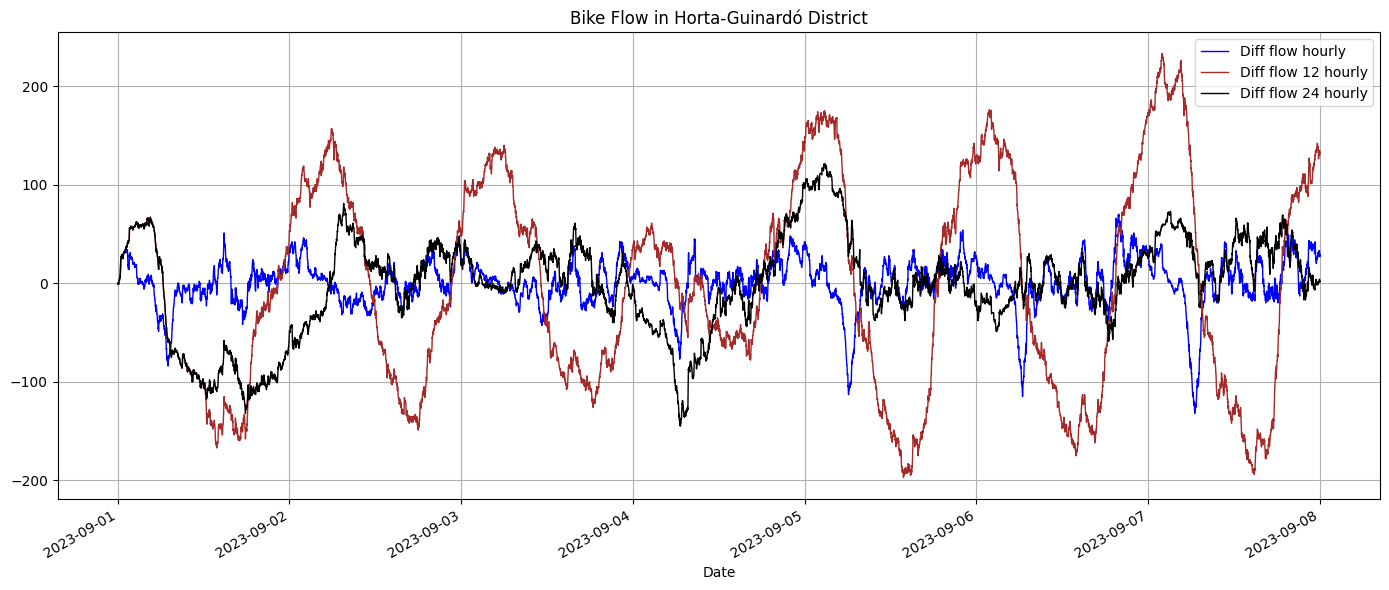

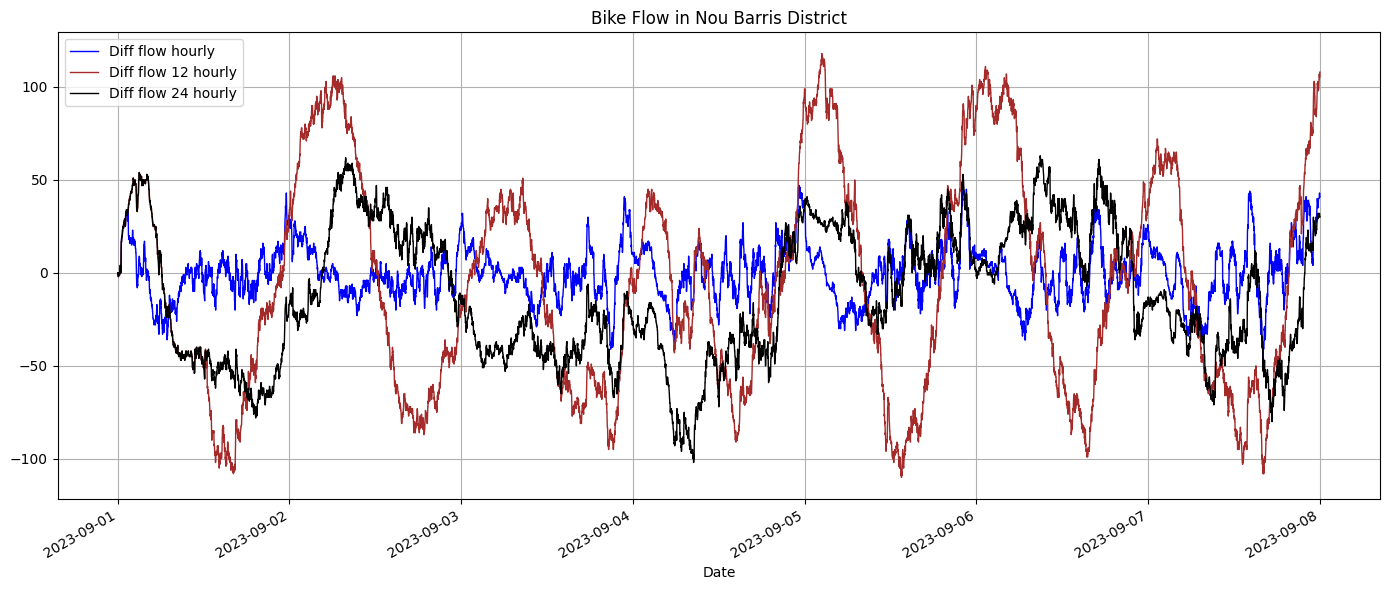

In [ ]:
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None 
# Load data
stations_master_file = main_folder + '/2024_05_Maig_BicingNou_INFORMACIO.csv'

# Read and sort station master data
stations_master = pd.read_csv(stations_master_file, low_memory=False)
stations_master['last_updated'] = pd.to_datetime(stations_master['last_updated'])
stations_master = stations_master.sort_values('last_updated').groupby('station_id').last()

# Add districts to stations data
stations_master = add_districts(stations_master)


stations_data = json_to_dataframe(files)
stations_data = stations_data[['timestamp_file', 'station_id', 'num_bikes_available']].sort_values(by=['station_id','timestamp_file'])

# Assuming 'stations_data' is defined elsewhere and properly loaded
districts = stations_master['district'].unique()

for district in districts:
    stations_in_district = stations_master[stations_master['district'] == district]['short_name'].tolist()
    stations_in_district = [str(int(station)) for station in stations_in_district]

    stations_data_filtered = stations_data[stations_data['station_id'].isin(stations_in_district)]
    
    stations_data_filtered.loc[:, 'diff'] = stations_data_filtered.groupby('station_id')['num_bikes_available'].diff().fillna(0)
    stations_data_filtered.loc[:, 'in_bikes'] = stations_data_filtered['diff'].apply(lambda x: x if x > 0 else 0)
    stations_data_filtered.loc[:, 'out_bikes'] = stations_data_filtered['diff'].apply(lambda x: -x if x < 0 else 0)
    stations_data_filtered['diff_bikes'] = stations_data_filtered['in_bikes'] - stations_data_filtered['out_bikes']
    
    
    stations_data_filtered.drop('diff', axis=1, inplace=True)

  
    flow_agg = stations_data_filtered.groupby('timestamp_file')[['diff_bikes']].sum().reset_index()
    flow_agg['timestamp_file'] = pd.to_datetime(flow_agg['timestamp_file'].astype(int), unit='s')
    flow_agg.set_index('timestamp_file', inplace=True)
    flow_agg['diff_bikes_hourly'] = flow_agg['diff_bikes'].rolling(window='1h').sum()
    flow_agg['diff_bikes_2hourly'] = flow_agg['diff_bikes'].rolling(window='2h').sum()
    flow_agg['diff_bikes_3hourly'] = flow_agg['diff_bikes'].rolling(window='3h').sum()
    flow_agg['diff_bikes_4hourly'] = flow_agg['diff_bikes'].rolling(window='4h').sum()
    flow_agg['diff_bikes_6hourly'] = flow_agg['diff_bikes'].rolling(window='6h').sum()
    flow_agg['diff_bikes_8hourly'] = flow_agg['diff_bikes'].rolling(window='8h').sum()
    flow_agg['diff_bikes_12hourly'] = flow_agg['diff_bikes'].rolling(window='12h').sum()
    flow_agg['diff_bikes_24hourly'] = flow_agg['diff_bikes'].rolling(window='24h').sum()
    flow_agg.reset_index(inplace=True)


    plt.figure(figsize=(14, 6))
    plt.plot(flow_agg['timestamp_file'], flow_agg['diff_bikes_hourly'], label='Diff flow hourly', color='blue', linewidth=1)
    #plt.plot(flow_agg['timestamp_file'], flow_agg['diff_bikes_2hourly'], label='Diff flow 2 hourly', color='green', linewidth=1)
    #plt.plot(flow_agg['timestamp_file'], flow_agg['diff_bikes_3hourly'], label='Diff flow 3 hourly', color='orange', linewidth=1)
    #plt.plot(flow_agg['timestamp_file'], flow_agg['diff_bikes_4hourly'], label='Diff flow 4 hourly', color='red', linewidth=1)
    #plt.plot(flow_agg['timestamp_file'], flow_agg['diff_bikes_6hourly'], label='Diff flow 6 hourly', color='pink', linewidth=1)
    plt.plot(flow_agg['timestamp_file'], flow_agg['diff_bikes_12hourly'], label='Diff flow 12 hourly', color='brown', linewidth=1)
    plt.plot(flow_agg['timestamp_file'], flow_agg['diff_bikes_24hourly'], label='Diff flow 24 hourly', color='black', linewidth=1)
    plt.title(f'Bike Flow in {district} District')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()
